In [32]:
%load_ext blackcellmagic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import requests
import json
import data_import
from OECD_function import *
from OECD_plot import plotme
import country_converter as coco
import plotly.graph_objects as go

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


# Internet Takeover

## The Questions

### What can internet usage say about a country?

* Does the adoption of internet affect educantional factors? If, so, which ones are most correlated?
* How has the internet impact the economy of a country?

## The Data

### CIA factbook and REST Countries API

Our first set of data was merged from the CIA factbook and REST Countries API. The REST API provided us with neccessary geographic data and the CIA factbook provided with information about the country in the year 2016. We were simply hoping to explore these data sets with specific endpoints that may  indicate  a correlation with the economic health of country, the level of education, and the level of internet users. 

#### Munging
 * Munging the CIA factbook is done in the .get_cia_countries() attribute of the data_import.py file. This file was json structure and was heavily nested so a lot of indexing was made to reference specific values. 
 * Munging the REST API consisted of a similar process except we had to call the API and request data from there.

In [2]:
rest_df = data_import.get_rest_countries()
cia_df = data_import.get_cia_data()
merged_data = pd.merge(rest_df, cia_df, how="inner", on="ISO3")
merged_data = merged_data[
    [
        "ISO3",
        "country_y",
        "region",
        "sub-region",
        "latitude",
        "longitude",
        "borders",
        "population",
        "internet_users",
        "internet_%_of_population",
        "median_age",
        "education_expenditures",
    ]
]
merged_data.head()

,ISO3,country_y,region,sub-region,latitude,longitude,borders,population,internet_users,internet_%_of_population,median_age,education_expenditures
0,AFG,Afghanistan,Asia,Southern Asia,33,65,"[IRN, PAK, TKM, UZB, TJK, CHN]",34940837.0,3531770.0,10.6,19.0,3.9
1,ALB,Albania,Europe,Southern Europe,41,20,"[MNE, GRC, MKD, KOS]",3057220.0,2016516.0,66.4,33.4,4.0
2,DZA,Algeria,Africa,Northern Africa,28,3,"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",41657488.0,17291463.0,42.9,28.3,NaN
3,ASM,American Samoa,Oceania,Polynesia,-14.3333,-170,[],50826.0,17000.0,31.3,26.1,NaN
4,AND,Andorra,Europe,Southern Europe,42.5,1.5,"[FRA, ESP]",85708.0,83887.0,97.9,44.9,3.2


## World Data

Our first step was taking a look at the big picture. We did this by beginning to visualize what the status of the world was regarding internet usage and statistics. We began using plotly to get an overall view of the world, then added a few graphs that being to paint the picture of what the global landscape of the internet looks like.

In [17]:
fig = go.Figure(
    data=go.Choropleth(
        locations=merged_data["ISO3"],
        z=merged_data["internet_%_of_population"],
        text=merged_data["country_y"],
        colorscale="Blues",
        autocolorscale=False,
        marker_line_color="darkgrey",
        marker_line_width=0.9,
        colorbar_title="Internet % of Population",
    )
)

fig.update_layout(
    title_text="Global Internet Usage by Country",
    geo=dict(showframe=False, showcoastlines=False, projection_type="equirectangular"),
)

fig.show()

## Observations

We decided to see how the different continents would stack up against other areas. We can see here that highest populated area is Asia, and it follows that Asia also has the highest amount of internet users compared with the other areas. Europe has a high percentage of internet users, where as Africa has a very low percentage of internet users.

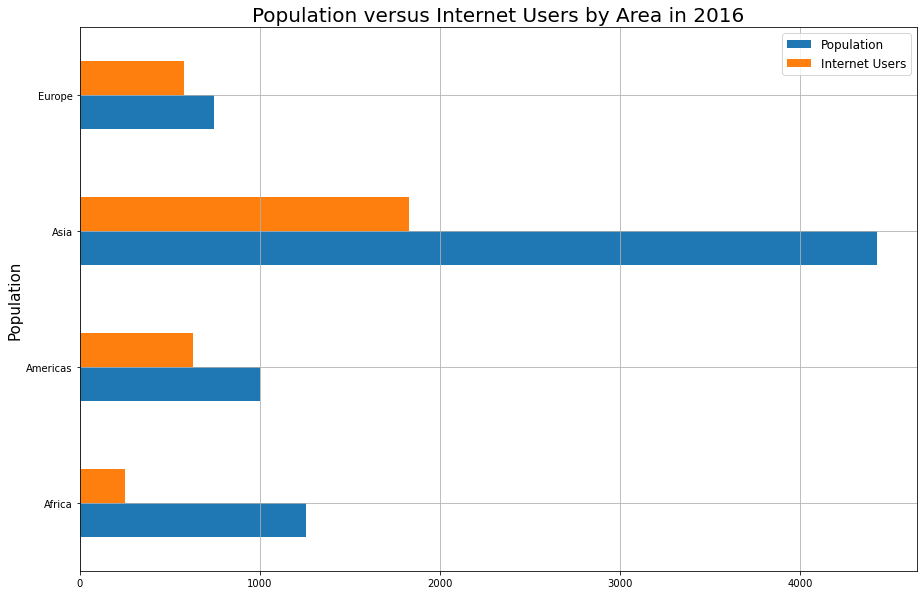

In [21]:
# Population versus Internet users by area
per_sub_area = (merged_data[["region", "population", "internet_users"]]).groupby(["region"]).sum()
per_sub_area = per_sub_area.drop("World")
per_sub_area = per_sub_area.drop("Polar")
per_sub_area = per_sub_area.drop("Oceania")

per_sub_area = round(per_sub_area/1000000,2)

#Plot Population vs Internet Users by Area in 2016
per_sub_area.plot(kind="barh", figsize=(15,10))

plt.title("Population versus Internet Users by Area in 2016", fontsize=20)
plt.ylabel("Population", fontsize = 15)
plt.xlabel('')
plt.legend(["Population", "Internet Users"], fontsize = 12);
plt.xticks(rotation=0)
plt.grid()

plt.savefig("Fig4.png")

#Show Figure
plt.show()

In this graph we can easily visualize that around half the world's population is an internet user. 3.2 B out of 7.5 B.

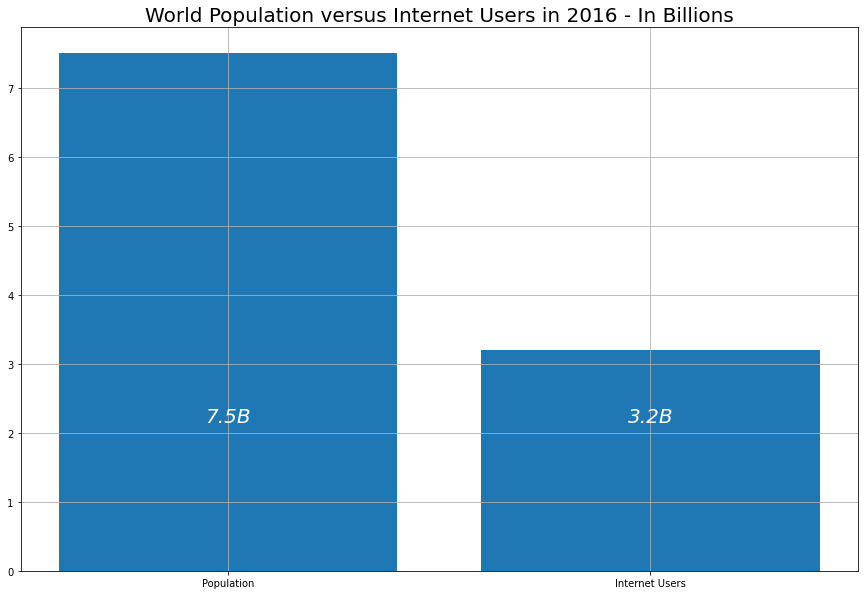

In [23]:
#plot World Population versus Internet Users
world2 = merged_data.iloc[226]
round_population = round(world2.population/1000000000,1)
round_users = round(world2.internet_users/1000000000,1)
data = {'Population': round_population, 'Internet Users': round_users}
names = list(data.keys())
values = list(data.values())
fig, axs = plt.subplots(1, 1, figsize=(15, 10), sharey=False)
plot = axs.bar(names, values)
plt.grid()
plt.title("World Population versus Internet Users in 2016 - In Billions",fontsize= 20)



def autolabel(rects):
    for idx, rect in enumerate(plot):
        height = rect.get_height() / abs(rect.get_height())*2
        axs.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                str(values[idx]) + 'B', size = '20', fontstyle = "oblique",
                ha='center', va='bottom', rotation=0, color = "white",)

autolabel(plot)

plt.show()

We took a closer look at the countries that have the highest internet use as well. 

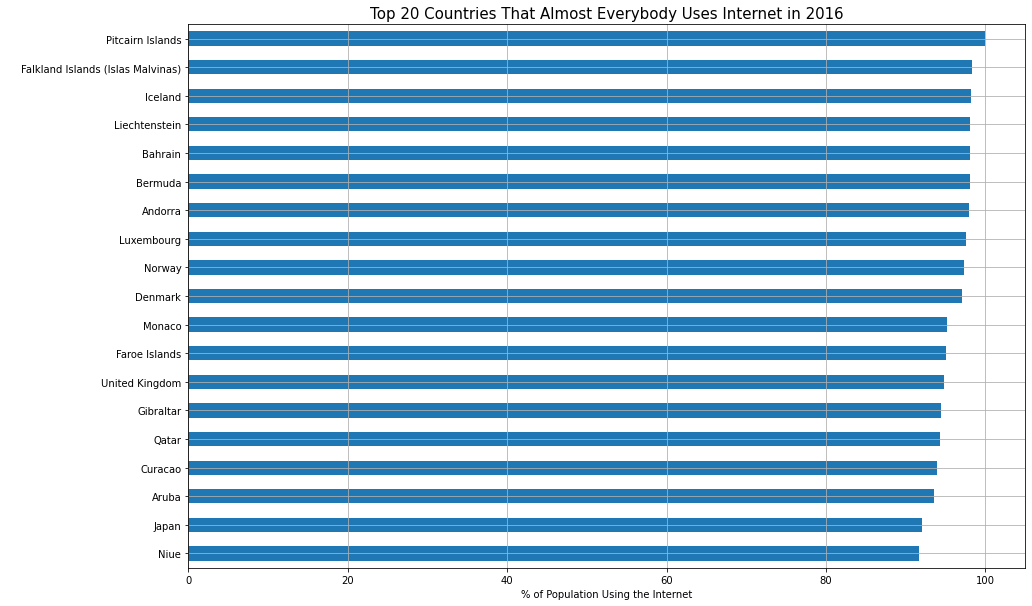

In [25]:
#What countries have almost 100% of their population using the Internet?
top_perc_internet_population = merged_data[["country_y", "internet_%_of_population"]]\
                            .sort_values(by=["internet_%_of_population"], ascending=False)\
                            .head(20)\
                            .sort_values(by=["internet_%_of_population"], ascending=True)\
                            .set_index("country_y")

top_perc_internet_population = top_perc_internet_population.drop("Antarctica")

#Plot top 20 countries that almost everyone uses the internet - 2016 data
top_perc_internet_population.plot(kind="barh", figsize=(15,10), legend=False)

plt.title("Top 20 Countries That Almost Everybody Uses Internet in 2016", fontsize=15)
plt.xlabel("% of Population Using the Internet")
plt.ylabel(' ')
plt.grid()

plt.savefig("Fig5.png")

#Show Figure
plt.show()

This was a very interesting Observation, that really led to more questions than answers. We expected a larger impact than this on internet usage for countries that invest more of their GDP into education. How much does the total GDP play a factor here? How are other areas impacted by the education GDP investment? Do countries with less resources that invest a higher percentage into education then increase life expectancy or other quality of life factors?

In [27]:
pop_low = merged_data["population"].quantile(0.1)
pop_hi = merged_data["population"].quantile(0.9)
edu_low = merged_data["education_expenditures"].quantile(0.01)
edu_hi = merged_data["education_expenditures"].quantile(0.99)


df_filtered = merged_data[
    (merged_data["population"] < pop_hi)
    & (merged_data["population"] > pop_low)
    & (merged_data["education_expenditures"] > edu_low)
    & (merged_data["education_expenditures"] < edu_hi)
]

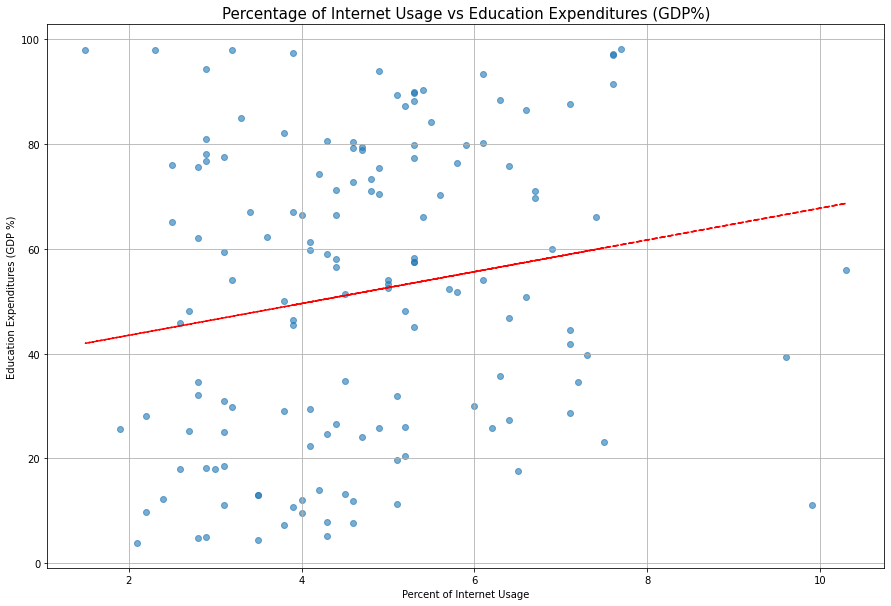

In [28]:
z = np.polyfit(
    df_filtered["education_expenditures"], df_filtered["internet_%_of_population"], 1
)
p = np.poly1d(z)

# Plot to show Percentage of internet Usage vs Education Expenditures (GDP%)
plt.figure(figsize=(15, 10))
plt.plot(
    df_filtered["education_expenditures"],
    p(df_filtered["education_expenditures"]),
    "r--",
)
plt.scatter(
    df_filtered["education_expenditures"],
    df_filtered["internet_%_of_population"],
    alpha=0.6,
)
plt.title("Percentage of Internet Usage vs Education Expenditures (GDP%)", fontsize=15)
plt.xlabel("Percent of Internet Usage")
plt.ylabel("Education Expenditures (GDP %)")
plt.grid()

plt.savefig("Fig1.png")

# Show Figure
plt.show()

We found an interesting trend here that correlates the older the median age with internet users. This might mean that smallers countries might adopt internet usage more fully than a big country with big wealth distribution. This could also mean better technology and therefore longer lifespan, but we do not have the data to support this fully.  This would be an interesting continuation of the research.

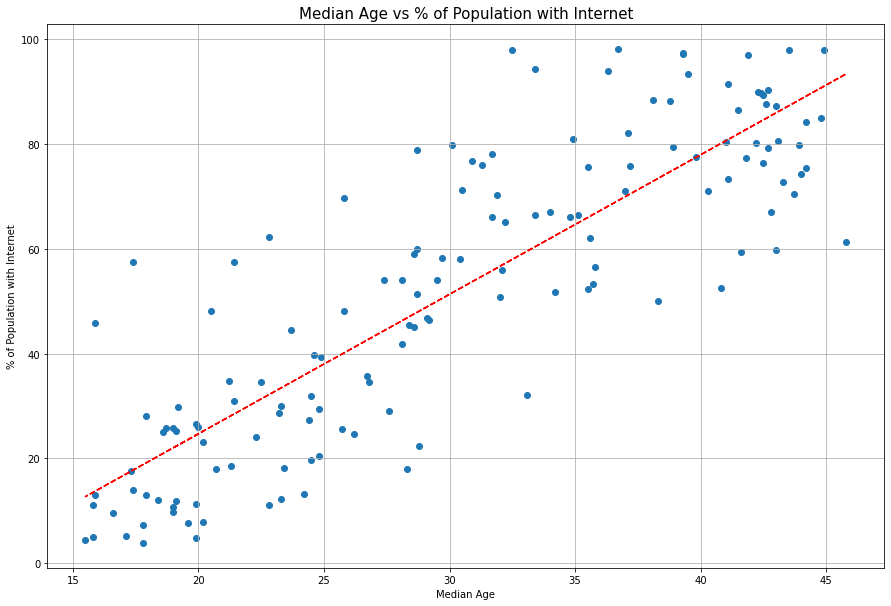

In [29]:
z_trend = np.polyfit(
    df_filtered["median_age"], df_filtered["internet_%_of_population"], 1
)
p_trend = np.poly1d(z_trend)

plt.figure(figsize=(15, 10))
plt.plot(df_filtered["median_age"], p_trend(df_filtered["median_age"]), "r--")
plt.scatter(df_filtered["median_age"], df_filtered["internet_%_of_population"])
plt.title("Median Age vs % of Population with Internet", fontsize=15)
plt.xlabel("Median Age")
plt.ylabel("% of Population with Internet")
plt.grid()

plt.savefig("Fig2.png")

plt.show()

### OECD DATA


The time scale observartions provide a progressive analysis of the data. We present four different endpoints to be compared with the countries' progressive adoption of broadband subscriptions (fixed or mobile). 

Our endpoints include:
* GDP per Capita at current PPP
 * this is good indicator of quality of life in a country
 * we noticed here a positive correlation between GDP per capita and internet subscriptions
 * This might mean that  the internet brought forth a lot of opportunities like creating more jobs and making goods continually cheaper
* Unemployment Rate
 * Unemployment rate goes down, for the most part, as internet subscriptions increase. 
 * This can easily be interpreted saying that the internet created more jobs and therefore it is easier to get a job because of the internet.
 * While this is true to a certain extent I think further investigation into how many of the jobs taken needed the internet to exist and how many of the jobs created were simply made easier with the internet. 
* GDP % spent Research and Development
 * This indicator pretty much flatlines in the grand sheme of things. This means countries don't want to allocate more of their GDP in Research and Development.
 * This, however, does not mean that countres are stagnant in their budget. Their GDP is increasing so they are spending more on R&D as well, this is just not portrayed as a percentage
* Value Added at PPP in R&D Sector
 * This is a good indicator of how much benfit a particcular industry brought the country. 
 * Value in R&D has increased with internet usage.
 * This could mean that the internet is helping researchers gather ideas faster and therefore develop and sell faster.
 

Our second set of data was intended to provide a analysis of the features we noticed in the first data set progressing annually. This sort of analysis forced us to narrow down our scope of study to 10 countries, since the graphs got too crowded. We will see how these 10 countries were picked in a few moments. The minging process on this dataset was relatively simple, simply indexing by endpoint/variable and then allocating values in a new dataframe showcasing the progress of that variable annualy, by country. 

In [36]:
path = os.path.join("OECD_data", "broadband.csv")

with open(path) as csv_file:
    og_broadband_df = pd.read_csv(csv_file)
og_bb_df = og_broadband_df[["Country", "VAR", "Time", "Value", "Unit"]]

path = os.path.join("OECD_data", "GERD.csv")

with open(path) as csv_file:
    GERD = pd.read_csv(csv_file)

GERD = GERD[["Country", 'ï»¿"MSTI_VAR"', "MSTI Variables", "Year", "Value"]]

path = os.path.join("OECD_data", "economic_outlook.csv")

with open(path) as csv_file:
    econ_df = pd.read_csv(csv_file)

econ_df = econ_df[["Country", "VARIABLE", "Variable", "Time", "Value"]]
fixed100_bb_df = get_var(og_bb_df, "BB-P100-TOT")
mob100_bb_df = get_var(og_bb_df, "BBW-P100-TOT")
fixed100_df = get_values(fixed100_bb_df[fixed100_bb_df["Time"].str.startswith("2")])
mobile100_df = get_values(mob100_bb_df[mob100_bb_df["Time"].str.startswith("2")])

fixed_bb_df = get_var(og_bb_df, "BB-SUBS-TOT")
mob_bb_df = get_var(og_bb_df, "BBW-SUBS-TOT")
fixed_df = get_values(fixed_bb_df[fixed_bb_df["Time"].str.startswith("2")])
mobile_df = get_values(mob_bb_df[mob_bb_df["Time"].str.startswith("2")])

POP = get_var(econ_df, "POP")
population = get_values(POP)

##fixed+mobile in persons
total_bb_df = pd.DataFrame()
for col in fixed_df.columns:
    total_bb_df[col] = fixed_df[col] + mobile_df[col]

total100_df = pd.DataFrame()
for col in total_bb_df.columns:
    total100_df[col] = (total_bb_df[col] / population[col]) * 100

total100_df = total100_df.dropna(axis=0)

##Research and Development
gdpRD = get_var(GERD, "G_XGDP")
gdpRD_df = get_values(gdpRD)

VA_PPP = get_var(GERD, "VA_PPP")
val_addedPPP = get_values(VA_PPP)

##economic_indicators
GDP_PPP = get_var(GERD, "GDP_PPP")
gdp_ppp = get_values(GDP_PPP)

UNR = get_var(econ_df, "UNR")
unemployment_rate = get_values(UNR)

GDPV_CAP = get_var(econ_df, "GDPV_CAP")
gdp_percapita = get_values(GDPV_CAP)

GDPVD_CAP = get_var(econ_df, "GDPVD_CAP")
gdp_pcapita_PPP = get_values(GDPVD_CAP)

In [37]:
total100plot = plotme(dataframes, total100_df)

NameError: name 'dataframes' is not defined